In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4"
os.chdir('app/')

In [2]:
import pandas as pd
import numpy as np
import torch
from functools import partial
import pytorch_lightning as pl
import warnings
warnings.filterwarnings("ignore")

from torch.utils.data import DataLoader

from ptls.data_load.datasets import MemoryMapDataset
from ptls.data_load.iterable_processing.iterable_seq_len_limit import ISeqLenLimit
from ptls.data_load.iterable_processing.to_torch_tensor import ToTorch
from ptls.data_load.iterable_processing.feature_filter import FeatureFilter
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.coles import CoLESModule
from ptls.data_load.iterable_processing import SeqLenFilter
from ptls.frames.coles import ColesIterableDataset
from ptls.frames.coles.split_strategy import SampleSlices
from ptls.frames import PtlsDataModule
from ptls.preprocessing import PandasDataPreprocessor
from ptls.data_load.utils import collate_feature_dict
from ptls.data_load.iterable_processing_dataset import IterableProcessingDataset

from tqdm.auto import tqdm
import lightgbm as ltb

In [3]:
path_to_data = 'data' # '.'

In [5]:
transactions_train = pd.read_parquet(f"{path_to_data}/trx_train.parquet")
transactions_test = pd.read_parquet(f"{path_to_data}/trx_test.parquet")

In [7]:
def preprocess(df):
    df.sort_values('event_time', inplace=True)

    df['time_diff'] = df.groupby('client_id')['event_time'].diff().dt.seconds // 60
    df['time_diff'] = df['time_diff'].fillna(0)

    df['month'] = df['event_time'].dt.month
    df['day_of_week'] = df['event_time'].dt.day_of_week
    df['hour'] = df['event_time'].dt.hour
    df['minute'] = df['event_time'].dt.minute

    df['amount'] = np.log1p(df['amount'])

    columns = ['event_type', 'event_subtype', 'currency', 'src_type11', 
               'src_type12', 'dst_type11', 'dst_type12', 'src_type21', 
               'src_type22', 'src_type31', 'src_type32', 'time_diff', 'month', 
               'day_of_week', 'hour', 'minute']
    
    for col in columns:
        if df[col].max() <= 127:
            df[col] = df[col].fillna(-1).astype('int8')

        elif df[col].max() <= 32767:
            df[col] = df[col].fillna(-1).astype('int16')

        else:
            df[col] = df[col].fillna(-1).astype('int32')

    return df

In [8]:
transactions_train_processed = preprocess(transactions_train)

In [13]:
transactions_train_processed.to_parquet('data_preprocessed/trx_train_preprocessed.parquet', index=False)

In [9]:
transactions_test_processed = preprocess(transactions_test)

In [ ]:
transactions_test.to_parquet('data_preprocessed/trx_test_preprocessed.parquet', index=False)

In [3]:
# transactions_train_processed = pd.read_parquet('data_preprocessed/trx_train_preprocessed.parquet')

<Axes: >

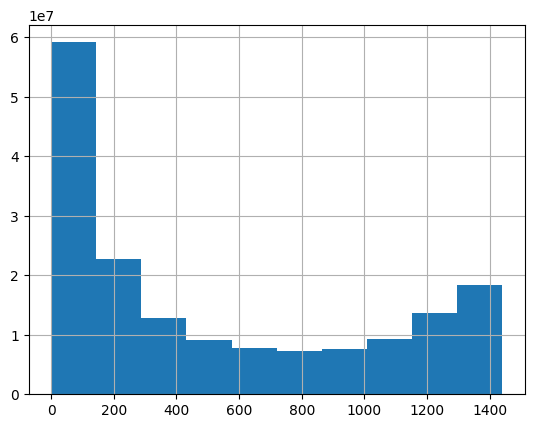

In [5]:
transactions_train_processed['time_diff'].hist()

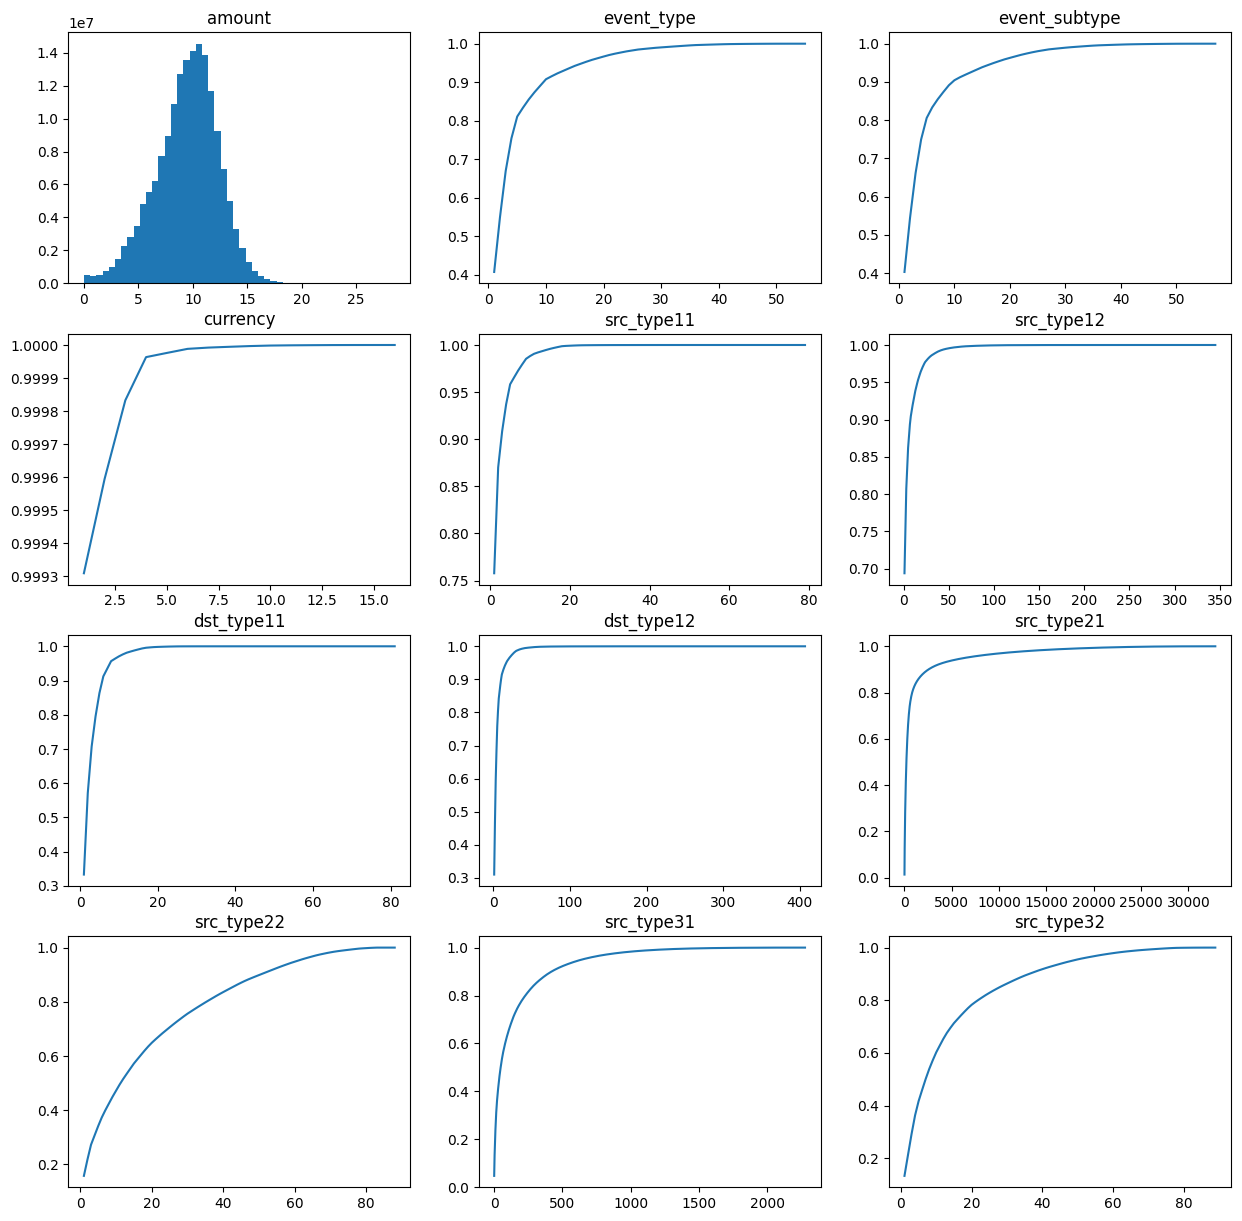

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.flatten()

axes[0].hist(transactions_train_processed['amount'], bins=50)
axes[0].set_title('amount')

for i, col in enumerate(['event_type', 'event_subtype', 'currency', 
                         'src_type11', 'src_type12', 'dst_type11', 'dst_type12',
                         'src_type21', 'src_type22', 'src_type31', 'src_type32']):
    
    stats = transactions_train_processed[col].value_counts(normalize=True)
    
    axes[i + 1].plot(np.arange(1, len(stats)+1), stats.cumsum().values)
    axes[i + 1].set_title(col)

# Geo

In [13]:
df = pd.read_parquet(f'{path_to_data}/geo_train.parquet/part-0.parquet')

df.head()

,client_id,event_time,geohash_4,geohash_5,geohash_6
0,309c0e909835757db908884e80f28f2fc76b803904b4b5...,2022-08-27 09:56:36.271169,39879,144891,1959174
1,309c0e909835757db908884e80f28f2fc76b803904b4b5...,2022-08-14 07:13:23.011804,39879,144891,1959174
2,309c0e909835757db908884e80f28f2fc76b803904b4b5...,2022-08-02 07:46:18.278369,39879,144891,1959174
3,309c0e909835757db908884e80f28f2fc76b803904b4b5...,2022-08-19 08:47:39.973788,39879,144891,1959174
4,309c0e909835757db908884e80f28f2fc76b803904b4b5...,2022-08-19 10:15:14.676360,39879,144891,1959174


In [6]:
def optimize(x):
    max_value = x.max()

    if max_value <= 127:
        return x.astype('int8')
    elif max_value <= 32767:
        return x.astype('int16')
    elif max_value <= 2147483647:
        return x.astype('int32')
    else:
        return x

In [7]:
import json


for k in [4, 5, 6]: # 
    dataframes = []

    for i in range(31):
        df = pd.read_parquet(f'{path_to_data}/geo_train.parquet/part-{i}.parquet')[f'geohash_{k}']
        dataframes.append(df)

    df = pd.concat(dataframes, axis=0)

    del dataframes

    counts = df.value_counts(normalize=True)
    popular_hashes = counts.index[:(counts.cumsum() < 0.99).sum()]
    # pd.Series(popular_hashes).to_csv(f'popular_hashes_{k}.csv', index=False)

    popular_hashes = set(popular_hashes)

    df = df.apply(lambda x: x if x in popular_hashes else -1) #.astype('int32')

    counts = df.value_counts()
    mapper = {hash: j+1 for j, hash in enumerate(counts.index)}

    with open(f'mapper_{k}.json', 'w') as fp:
        json.dump(mapper, fp)

    df = optimize(df.map(mapper))

    df.to_frame().to_parquet(f'geohash_{k}.parquet', index=False)

    del df

In [5]:
dataframes = []

for i in range(31):
    df = pd.read_parquet(f'{path_to_data}/geo_train.parquet/part-{i}.parquet')[['client_id', 'event_time']]
    dataframes.append(df)

df = pd.concat(dataframes, axis=0)

del dataframes

df.sort_values('event_time', inplace=True)

df['time_diff'] = (df.groupby('client_id')['event_time'].diff().dt.seconds // 60)
df['time_diff'] = df['time_diff'].fillna(0).astype('int16')

df.sort_index(inplace=True)

df['month'] = df['event_time'].dt.month.astype('int8')
df['day_of_week'] = df['event_time'].dt.day_of_week.astype('int8')
df['hour'] = df['event_time'].dt.hour.astype('int8')
df['minute'] = df['event_time'].dt.minute.astype('int8')

df

,client_id,event_time,time_diff,month,day_of_week,hour,minute
0,71f25293aa28d1b389653ba4365052bfd7fba2af2e6ee2...,2022-07-27 13:56:17.738915,210,7,2,13,56
0,951924008daa07fad645e7758453e883b753f31d69be46...,2022-05-10 08:20:14.702746,0,5,1,8,20
0,7a3f830c4113d19904171a9aebaacc151188b326505b1c...,2022-11-04 09:42:51.887417,16,11,4,9,42
0,07e0584cb8338a31c09ee58ccd29aad4ddd9a12d736c43...,2022-07-26 06:31:00.092057,548,7,1,6,31
0,ff46c1b6c27ac8401e87effbaa569b893dc2f3f08e61ba...,2022-03-15 15:14:45.205827,0,3,1,15,14
...,...,...,...,...,...,...,...
17331966,d78555cf90214679a1a57347fa4535b866d2535f1fa1a9...,2022-10-03 09:27:11.359793,30,10,0,9,27
17331966,4a195a0899e59d2fa2fb0549d9ad1da613d81a29f43f5f...,2022-11-13 03:49:40.226455,543,11,6,3,49
17331966,6590fef3f66b31fcfd714438d2bafc63fc410f05763955...,2022-11-05 04:22:34.621892,145,11,5,4,22
17331966,f3175b36c5dec50d9e1eed79c9024256d1f0d7ac017469...,2022-08-21 02:45:09.961066,27,8,6,2,45


In [9]:
df['geohash_4'] = pd.read_parquet('geohash_4.parquet')['geohash_4']
df['geohash_5'] = pd.read_parquet('geohash_5.parquet')['geohash_5']
df['geohash_6'] = pd.read_parquet('geohash_6.parquet')['geohash_6']

In [10]:
df

,client_id,event_time,time_diff,month,day_of_week,hour,minute,geohash_4,geohash_5,geohash_6
0,71f25293aa28d1b389653ba4365052bfd7fba2af2e6ee2...,2022-07-27 13:56:17.738915,210,7,2,13,56,87,857,55261
0,951924008daa07fad645e7758453e883b753f31d69be46...,2022-05-10 08:20:14.702746,0,5,1,8,20,87,857,55261
0,7a3f830c4113d19904171a9aebaacc151188b326505b1c...,2022-11-04 09:42:51.887417,16,11,4,9,42,87,857,55261
0,07e0584cb8338a31c09ee58ccd29aad4ddd9a12d736c43...,2022-07-26 06:31:00.092057,548,7,1,6,31,87,857,55261
0,ff46c1b6c27ac8401e87effbaa569b893dc2f3f08e61ba...,2022-03-15 15:14:45.205827,0,3,1,15,14,87,857,55261
...,...,...,...,...,...,...,...,...,...,...
17331966,d78555cf90214679a1a57347fa4535b866d2535f1fa1a9...,2022-10-03 09:27:11.359793,30,10,0,9,27,159,784,7528
17331966,4a195a0899e59d2fa2fb0549d9ad1da613d81a29f43f5f...,2022-11-13 03:49:40.226455,543,11,6,3,49,159,784,7528
17331966,6590fef3f66b31fcfd714438d2bafc63fc410f05763955...,2022-11-05 04:22:34.621892,145,11,5,4,22,159,784,7528
17331966,f3175b36c5dec50d9e1eed79c9024256d1f0d7ac017469...,2022-08-21 02:45:09.961066,27,8,6,2,45,159,784,7528


In [ ]:
df.to_parquet('data_preprocessed/geo_train_preprocessed.parquet', index=False)

In [4]:
geo_test = pd.read_parquet(f'{path_to_data}/geo_test.parquet')

In [11]:
import json

for k in [4, 5, 6]:
    with open(f'mapper_{k}.json', 'r') as f:
        mapper = json.load(f)

    geo_test[f'geohash_{k}'] = geo_test[f'geohash_{k}'].astype('str').map(mapper).fillna(-1).astype('int')

In [16]:
geo_test.sort_values('event_time', inplace=True)

geo_test['time_diff'] = (geo_test.groupby('client_id')['event_time'].diff().dt.seconds // 60)
geo_test['time_diff'] = geo_test['time_diff'].fillna(0).astype('int16')

geo_test.sort_index(inplace=True)

geo_test['month'] = geo_test['event_time'].dt.month.astype('int8')
geo_test['day_of_week'] = geo_test['event_time'].dt.day_of_week.astype('int8')
geo_test['hour'] = geo_test['event_time'].dt.hour.astype('int8')
geo_test['minute'] = geo_test['event_time'].dt.minute.astype('int8')

In [ ]:
geo_test.to_parquet('data_preprocessed/geo_test_preprocessed.parquet', index=False)